# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [41]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy
import itertools

# Загружаем данные

И разделяем их на training и validation.

In [43]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [44]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [45]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [46]:
# TODO: In model.py, implement compute_loss_and_gradients function
np.random.seed(42)
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [47]:
# TODO Now implement l2 regularization in the forward and backward pass
np.random.seed(42)
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [48]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.16666666666666666

# Допишем код для процесса тренировки

In [49]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD())

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302282, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302335, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301352, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302227, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302510, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303264, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302688, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302730, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302558, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302902, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302281, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301219, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302843, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302302, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302330, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302014, Train acc

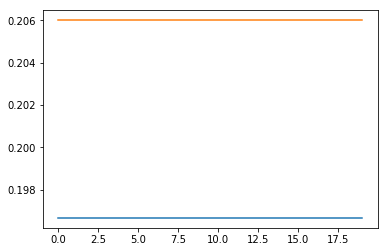

In [50]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [51]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.315232, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314569, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324904, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299182, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294934, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317467, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274845, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295497, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.254780, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250698, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272214, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271119, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266598, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.252840, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262644, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.261127, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [52]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.321419, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311102, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305809, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304392, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280724, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294068, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286835, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273778, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.309248, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253309, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.245964, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284582, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262997, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297839, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294309, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299918, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [53]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.335153, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.335385, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.306737, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.325895, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.266779, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.228525, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.240148, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.243602, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.346939, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 1.974729, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.998873, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.787597, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.258111, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.721385, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.293751, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.798342, Train acc

Loss: 1.210620, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.448190, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.153532, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.297928, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.358164, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.258632, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.427517, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.287220, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.316205, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.162056, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.318770, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.235518, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.292061, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.383995, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.056211, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.157474, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [54]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

regs = [1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-8, 1e-10]
batch_sizes = [1, 3, 5, 8, data_size]
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
learning_rates_decays = [1.0, 0.99, 0.98]

min_loss = np.finfo('f').max
min_loss_data = ()

loss_history = []
train_history = []
val_history = []

for hyper_params in itertools.product(regs, batch_sizes, learning_rates, learning_rates_decays):
    (reg, batch_size, learning_rate, learning_rates_decay) = hyper_params
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = reg)
    dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
    # TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
    trainer = Trainer(model, dataset, SGD(), learning_rate=learning_rate, num_epochs=20, batch_size=batch_size, learning_rate_decay=learning_rates_decay)

    t_loss_history, t_train_history, t_val_history = trainer.fit()
    if t_loss_history[-1] < min_loss:
        min_loss = t_loss_history[-1]
        min_loss_data = hyper_params
        
        loss_history = t_loss_history
        train_history = t_train_history
        val_history = t_val_history

Loss: 2.282875, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.197384, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.550085, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.147767, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 1.375068, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.056712, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.066313, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 1.042761, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.381335, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 5.332339, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 0.429611, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.243982, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 2.362580, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 1.148665, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 0.759628, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.892289, Train acc

Loss: 2.320325, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.338712, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.336577, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.315361, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.326658, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.337577, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.310751, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.339672, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.324207, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.340329, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.339267, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.341800, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301449, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.333355, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.331560, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.331204, Train acc

Loss: 2.333853, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.334136, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.334120, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.334048, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.334086, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.334034, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.332339, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.335705, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333023, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332842, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333262, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332848, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.335671, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332984, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332856, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333561, Train acc

Loss: 2.331305, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.329011, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.326470, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.311638, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319574, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.328630, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319329, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310936, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298898, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.336191, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.289449, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.323463, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296950, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296922, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.321652, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.276973, Train acc

Loss: 2.333432, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333410, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.332839, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333032, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.332712, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333184, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333102, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333227, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333897, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333196, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333114, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.333433, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.333042, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333562, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.334103, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333624, Train acc

Loss: 2.310462, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.327301, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.154424, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.338599, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.280482, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.340348, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.775262, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.890106, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.813031, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.214760, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.320029, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.909348, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.783068, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.334551, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.333171, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.330226, Train acc

Loss: 2.332569, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333995, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333460, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333502, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333463, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333515, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333316, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333150, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333874, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333269, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333937, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.334011, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.332378, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.332052, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333723, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.332198, Train acc

Loss: 2.338400, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.339135, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303818, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303895, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.281575, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.309332, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.303168, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.274483, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.279681, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.273064, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.233267, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.246272, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.214529, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.287394, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.122687, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.891727, Train acc

Loss: 2.332605, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.332149, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.332830, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.332031, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.332525, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.332188, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.330967, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.331734, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.331412, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333762, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333212, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332976, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333502, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333122, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333036, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333070, Train acc

Loss: 2.333177, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333436, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333025, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333754, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333330, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332790, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332405, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333044, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333727, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333089, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332907, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333377, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333566, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333875, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332990, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333635, Train acc

Loss: 2.326974, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.326625, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.326284, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.325951, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.325627, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.333185, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333134, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333084, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.333033, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332982, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332932, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332881, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332831, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332780, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332730, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332679, Train acc

Loss: 2.333400, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333399, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333399, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333398, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333398, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333397, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333397, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333396, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333396, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333395, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.333432, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.333432, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.333431, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.333431, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.333430, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.333430, Train acc

/Users/jetbrains/csc/CSC_4_sem_dlcourse/dlcourse_ai/assignments/assignment2/layers.py:70: RuntimeWarning: divide by zero encountered in log
  loss -= np.log(row_probs[class_idx])


Loss: 457.556805, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 2.239561, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.487897, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.521804, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.599104, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.530402, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 0.375699, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 0.099962, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 2.612881, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.541371, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.367389, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 3.349427, Train accuracy: 0.266667, val accuracy: 0.200000
Loss: 0.815444, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 3.552581, Train accuracy: 0

Loss: 2.309452, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.312412, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.304149, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301851, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301333, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300868, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.288473, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.312568, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.286677, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.283420, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300575, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300154, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.315041, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.279210, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.315191, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.306638, Train acc

Loss: 2.305635, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305955, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305662, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.304313, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305399, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305049, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305809, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305871, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305607, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.306303, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.305283, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.305268, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.305285, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.304889, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.304893, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.304860, Train acc

Loss: 2.307896, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304743, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302983, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301610, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304832, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298728, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304510, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.273138, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.311572, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.293207, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.291388, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302539, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.288482, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.249119, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.314358, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.272816, Train acc

Loss: 2.305010, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305917, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305392, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305865, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305711, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305449, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305329, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305474, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.305230, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.305354, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.305264, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.305408, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.306008, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.305449, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.306341, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.305931, Train acc

Loss: 2.296755, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299605, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299458, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.287967, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.281594, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.297930, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.271537, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.303263, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.273867, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.279873, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.307136, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305993, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303539, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301921, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.308597, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296910, Train acc

Loss: 2.305088, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.306361, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305069, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305419, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305421, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305389, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305866, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305893, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305973, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.304812, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305179, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.304505, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305038, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305329, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.304466, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.305426, Train acc

Loss: 1.951840, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.805795, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.950017, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.823946, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.995842, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.900144, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.305403, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304014, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300700, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.269306, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.263394, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.250300, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.269315, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.252340, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.252321, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.222569, Train acc

Loss: 2.305541, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.306151, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305278, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304482, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304870, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304896, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.304538, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.304078, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.305181, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305753, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.305481, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.306021, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.303755, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.303521, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305044, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304247, Train acc

Loss: 2.305723, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301882, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298132, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.294460, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.290857, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.287313, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.283811, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.280332, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.276848, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.273327, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.269716, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.265945, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.261919, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.257501, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.252501, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.246658, Train acc

Loss: 2.305382, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305343, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305304, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305266, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305227, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305189, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305150, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305111, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305073, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305034, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304996, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304957, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305878, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305839, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305801, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.305762, Train acc

Loss: 2.305667, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305666, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305666, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305665, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305665, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305665, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305664, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305664, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305664, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305664, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305663, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305663, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305663, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305662, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305662, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.305662, Train acc

Loss: 2.134332, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.375738, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 1.722142, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.124126, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.126780, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.241447, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.035348, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.304659, Train accuracy: 0.200000, val accuracy: 0.200000
Loss: 2.299950, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.306892, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297046, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296248, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.294764, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.308879, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.307673, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298459, Train acc

Loss: 2.302111, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302096, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.304263, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303036, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303059, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.301483, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.301488, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302057, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302710, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303473, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302681, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.301853, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.301982, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.301823, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303870, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302675, Train acc

Loss: 2.253185, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.251423, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.246130, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.257525, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.294850, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.273036, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.292595, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.302280, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299801, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300437, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298708, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.308180, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.295503, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.293991, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.286168, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.309767, Train acc

Loss: 2.302949, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302952, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302034, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303126, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303019, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302122, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303108, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303006, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302537, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303071, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301865, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302862, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303025, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302398, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303122, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303403, Train acc

Loss: 2.313665, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.249376, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.249496, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.274613, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.243195, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.257100, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.010157, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.943494, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.765709, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.742524, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.696103, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.903062, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.330376, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.850953, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.777411, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.922354, Train acc

Loss: 2.302092, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301663, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300788, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302954, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.303057, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302947, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.303681, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302727, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.303237, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302799, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302843, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.303089, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302385, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302761, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302860, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302927, Train acc

Loss: 2.297064, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.283669, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.276143, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.284535, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.252749, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.274873, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.260492, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.224595, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.250815, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.185520, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.169117, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.981494, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.887915, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.041416, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.730848, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.052464, Train acc

Loss: 2.302451, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302245, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.301899, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.301639, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.301648, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 2.301588, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.302309, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.300821, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 2.303197, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.303123, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303164, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302378, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303217, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302770, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302236, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301962, Train acc

Loss: 2.303126, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302805, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303333, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302904, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302651, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302970, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303117, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302598, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302996, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302937, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302916, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302924, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302866, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302580, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303025, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299183, Train acc

Loss: 2.302635, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302596, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302785, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302747, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302708, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302671, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302633, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302596, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 2.302559, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302523, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302487, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302451, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.302416, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.302381, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.302347, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.302312, Train acc

Loss: 2.302636, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302636, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302636, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302635, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302635, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302635, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302634, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302634, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302634, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302847, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302847, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302847, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302846, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302846, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302846, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302845, Train acc

Loss: 2.034363, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.024549, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.995883, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.307369, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.282731, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.267722, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.255286, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.334929, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.338830, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.342699, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.205307, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.269599, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.358020, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.148681, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.250088, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.155603, Train acc

Loss: 2.301899, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302524, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301718, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301636, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303654, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299909, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299734, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303534, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299572, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303457, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303334, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299191, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302966, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302583, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.300948, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302846, Train acc

Loss: 2.290000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.288537, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.278045, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.282155, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.290743, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.289010, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298178, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296089, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.284367, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.264927, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.280914, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.280589, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.257732, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.277925, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.257821, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.272121, Train acc

Loss: 2.303037, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302500, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302465, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.303063, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.303376, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302525, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302870, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302333, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302879, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302684, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302065, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.301857, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.303174, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302541, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302192, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302057, Train acc

Loss: 1.658344, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.201773, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.268877, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.506700, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.549564, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 2.303096, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.308630, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.295094, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.259944, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303392, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.266352, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.283527, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.200104, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.069293, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.132749, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.944165, Train acc

Loss: 2.301652, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301551, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300752, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301900, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301398, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301253, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301299, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301189, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300921, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300291, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299795, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300446, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303001, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302546, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302923, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302045, Train acc

Loss: 2.197351, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.136990, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.018201, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.153216, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.924437, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.107171, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.043138, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.838774, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.944402, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.782090, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.905662, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.309095, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.297109, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.284841, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.280895, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.266602, Train acc

Loss: 2.300386, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302246, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302263, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302468, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301927, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302176, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301945, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301837, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301956, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301689, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302276, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301040, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302357, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300738, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300499, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301723, Train acc

Loss: 2.302108, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302533, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302184, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302314, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302711, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302661, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302468, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302591, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302483, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302821, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302525, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302558, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302320, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302206, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.301894, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302568, Train acc

Loss: 2.302399, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302012, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301633, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301263, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300900, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300546, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300199, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299860, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299528, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.299203, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298886, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298575, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298270, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.297972, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.297681, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.297396, Train acc

Loss: 2.302268, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302267, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302267, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302266, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302266, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302266, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302265, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302265, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302264, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302248, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302248, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302248, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302247, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302247, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302246, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302246, Train acc

Loss: 2.307296, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.283542, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297726, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.292561, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.287929, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.283147, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.213545, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.192342, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.353593, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.359392, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.364209, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.367563, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.150090, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 1.801735, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.131470, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.264020, Train acc

Loss: 2.299274, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305311, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302195, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298997, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303650, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305479, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302361, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298780, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298654, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301557, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.303169, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303244, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303469, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302389, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300852, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300715, Train acc

Loss: 0.854294, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 0.546818, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 2.318404, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.295143, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.232388, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.248010, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.289672, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.438005, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.003851, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.178101, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.728791, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.758698, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.176133, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.710859, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 0.508897, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.992159, Train acc

Loss: 2.302239, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303237, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303188, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303554, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301035, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302079, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.295534, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303637, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.305434, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299938, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298376, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301924, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302737, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302437, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302383, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302661, Train acc

Loss: 1.826020, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.075205, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.910137, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.677852, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.833214, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.705429, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.382213, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.858338, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.724588, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.504448, Train accuracy: 0.466667, val accuracy: 0.066667
Loss: 1.770685, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 2.297830, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.308452, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.271830, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.283938, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.266869, Train acc

Loss: 2.302188, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302982, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302341, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301185, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301368, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302087, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301386, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301284, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300835, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303757, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300993, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302770, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302981, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302590, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302569, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302844, Train acc

Loss: 2.302558, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302636, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302863, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302645, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302555, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302187, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302835, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302823, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302485, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302831, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302987, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302570, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302309, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302819, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302918, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302094, Train acc

Loss: 2.302550, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.303008, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.301258, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 2.301424, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302390, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301559, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301765, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301769, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301637, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302709, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302566, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302414, Train accuracy: 0.133333, val accuracy: 0.266667
Loss: 2.301983, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302447, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302227, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.301935, Train acc

Loss: 2.302578, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302493, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302652, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302671, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302266, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302255, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.301840, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302261, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 2.302079, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 2.302050, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 2.302838, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 2.302356, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 2.302284, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302580, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302654, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302671, Train acc

Loss: 2.301793, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301423, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301062, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300708, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300362, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300024, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299693, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299369, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299052, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298742, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298438, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298141, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297850, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297566, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297287, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297014, Train acc

Loss: 2.302592, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302590, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302587, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302584, Train accuracy: 0.066667, val accuracy: 0.000000
Loss: 2.302651, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302651, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302651, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302650, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302650, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302649, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302649, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302649, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302648, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302648, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302648, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302647, Train acc

Loss: 2.185041, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.272272, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.251638, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.258172, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.131667, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 1.762970, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.390968, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.582717, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.035873, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.421155, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.393034, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.099267, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.064342, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.315448, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 2.320257, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296390, Train acc

Loss: 2.300323, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.304136, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300014, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303021, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302577, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.301577, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302279, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303520, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302240, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.301845, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.304482, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302089, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302134, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301786, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302447, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300979, Train acc

Loss: 2.253615, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.052030, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.255401, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.393264, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.619672, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.308289, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.207536, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.479602, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.154064, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 1.452530, Train accuracy: 0.400000, val accuracy: 0.066667
Loss: 1.152972, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 0.743526, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 0.905862, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 1.215652, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 1.428050, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 1.539469, Train acc

Loss: 2.300295, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298339, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300981, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303912, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.294637, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.296399, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302649, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300980, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301933, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303166, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301736, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302417, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301105, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301774, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302013, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301193, Train acc

Loss: 2.302752, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301655, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301211, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302238, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.303030, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301383, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301143, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301690, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302467, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302426, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301806, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302372, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302466, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302531, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301746, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302006, Train acc

Loss: 2.289569, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.295193, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.288417, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.294974, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.287237, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302437, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 2.302748, Train accuracy: 0.133333, val accuracy: 0.133333
Loss: 2.302656, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302197, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.302091, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302029, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302390, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301760, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301840, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301298, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302235, Train acc

Loss: 2.302253, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302371, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302276, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302703, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302369, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303008, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302243, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302555, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302449, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302878, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302551, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302287, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.302700, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303445, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.303191, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302639, Train acc

Loss: 2.286966, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.303899, Train accuracy: 0.200000, val accuracy: 0.000000
Loss: 2.301562, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302354, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301935, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299016, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299080, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298570, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299417, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.291757, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296710, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.293985, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297435, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.294967, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296562, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.290791, Train acc

Loss: 2.302329, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302525, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302063, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302469, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.302191, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: 2.301845, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302393, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302710, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302547, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302505, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302363, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302298, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302162, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302440, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.301821, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302239, Train acc

Loss: 2.301780, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301395, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301012, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300629, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300247, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299865, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299484, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299104, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298725, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298346, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297968, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297590, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.297213, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296837, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296461, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296086, Train acc

Loss: 2.302684, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302680, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302677, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302673, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302669, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302665, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302661, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302657, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302863, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302859, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302856, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302852, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302848, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302844, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302841, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: 2.302837, Train acc

Loss: 2.517026, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 1.913016, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 4.637967, Train accuracy: 0.333333, val accuracy: 0.200000
Loss: 1.825190, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 2.047663, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 0.007042, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 2.396024, Train accuracy: 0.466667, val accuracy: 0.133333
Loss: 1.874309, Train accuracy: 0.666667, val accuracy: 0.000000
Loss: 0.883904, Train accuracy: 0.533333, val accuracy: 0.200000
Loss: 3.226837, Train accuracy: 0.533333, val accuracy: 0.133333
Loss: 7.412279, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.169273, Train accuracy: 0.733333, val accuracy: 0.066667
Loss: 0.000006, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.895579, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.046201, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.017054, Train acc

Loss: 2.287495, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.296269, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.309658, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.295388, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.294975, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.280409, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.294265, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.311742, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.293215, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.303808, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301478, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.304738, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298677, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.295839, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.294482, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.293153, Train acc

Loss: 2.302358, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.304464, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.304928, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.304329, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.302287, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.302283, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.304473, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.302993, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.302416, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.304357, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.302839, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.302977, Train accuracy: 0.000000, val accuracy: 0.133333
Loss: 2.301535, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.302249, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.304298, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: 2.302292, Train acc

Loss: 2.285205, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.283389, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.283397, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.268752, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.249827, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.280089, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.277764, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.276858, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302216, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302495, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302970, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300572, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302259, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.300959, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301716, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302322, Train acc

Loss: 2.302082, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302103, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302678, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.301225, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302194, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303496, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303097, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302178, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302689, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.301666, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302496, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302240, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.303383, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302024, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302667, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.301218, Train acc

Loss: 2.298514, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.293549, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.289350, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.291549, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.290849, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301432, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300863, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.295087, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.280788, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.266134, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.293316, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.276488, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.302678, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301333, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301121, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.298452, Train acc

Loss: 2.302199, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302016, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302831, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302530, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302685, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302063, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302276, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302600, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302942, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302901, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302204, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302021, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302178, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.301740, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.301897, Train accuracy: 0.066667, val accuracy: 0.066667
Loss: 2.302375, Train acc

Loss: 2.241046, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.250340, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.207434, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.270931, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.154778, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.222803, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.052000, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.952239, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.197194, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.794098, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.601631, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.726944, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.726718, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.302419, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302119, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301538, Train acc

Loss: 2.303112, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.303106, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.301965, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302937, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302727, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302880, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302842, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302958, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302115, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302492, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302943, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302862, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.303407, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302559, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302409, Train accuracy: 0.133333, val accuracy: 0.000000
Loss: 2.302348, Train acc

Loss: 2.263302, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.259383, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.255133, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.250415, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.245054, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.238824, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.231441, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.222561, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.211766, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.302409, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298586, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.294910, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.291372, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.287957, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.284651, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.281440, Train acc

Loss: 2.301928, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.301901, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302484, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302480, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302477, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302473, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302469, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302465, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302461, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302457, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302453, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302450, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302446, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302442, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302438, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.302434, Train acc

In [55]:
print(min_loss_data)
print(f"Train: {train_history}")
print(f"Val: {val_history}")

(1e-10, 1, 0.1, 0.99)
Train: [0.2, 0.26666666666666666, 0.26666666666666666, 0.26666666666666666, 0.3333333333333333, 0.3333333333333333, 0.4, 0.26666666666666666, 0.4, 0.4666666666666667, 0.6666666666666666, 0.5333333333333333, 0.5333333333333333, 0.7333333333333333, 0.7333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0]
Val: [0.13333333333333333, 0.0, 0.13333333333333333, 0.13333333333333333, 0.06666666666666667, 0.2, 0.13333333333333333, 0.06666666666666667, 0.13333333333333333, 0.13333333333333333, 0.0, 0.2, 0.13333333333333333, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667]


In [62]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-10)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=0.1, num_epochs=20, batch_size=1, learning_rate_decay=0.99)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.336439, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.151497, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.014421, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: 0.207144, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.493954, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 1.960991, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.484883, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 2.455227, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 2.245985, Train accuracy: 0.600000, val accuracy: 0.133333
Loss: 0.359584, Train accuracy: 0.666667, val accuracy: 0.066667
Loss: 0.187651, Train accuracy: 0.600000, val accuracy: 0.000000
Loss: 1.220381, Train accuracy: 0.800000, val accuracy: 0.066667
Loss: 1.836532, Train accuracy: 0.933333, val accuracy: 0.066667
Loss: 0.005905, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.024406, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.121817, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [57]:
# Let's train the best one-hidden-layer network we can

regs = [1e-1, 1e-3, 1e-5]
batch_sizes = [32, 64]
learning_rates = [1e-1, 1e-3, 1e-5]
learning_rates_decays = [1.0, 0.999, 0.99]
hidden_layer_sizes = [64, 128, 256]
nums_epochs = [20]

best_classifier = None
best_val_accuracy = None
best_hyper_params = None

loss_history = []
train_history = []
val_history = []

for hyper_params in itertools.product(regs, batch_sizes, learning_rates, learning_rates_decays, hidden_layer_sizes, nums_epochs):
    (reg, batch_size, learning_rate, learning_rates_decay, hidden_layer_size, num_epochs) = hyper_params
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg)
    dataset = Dataset(train_X, train_y, val_X, val_y)
    trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, num_epochs=num_epochs, batch_size=batch_size, learning_rate_decay=learning_rates_decay)

    t_loss_history, t_train_history, t_val_history = trainer.fit()
    
    if best_val_accuracy is None or best_val_accuracy < t_val_history[-1]:
        best_classifier = trainer
        best_val_accuracy = t_val_history[-1]
        best_hyper_params = hyper_params
        
        loss_history = t_loss_history
        train_history = t_train_history
        val_history = t_val_history

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.293086, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283759, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.080949, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.219204, Train accuracy: 0.160000, val accuracy: 0.146000
Loss: 2.269509, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.140461, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.191203, Train accuracy: 0.156222, val accuracy: 0.181000
Loss: 2.394557, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280128, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.209358, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.180251, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.165689, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.323078, Train accuracy: 0.194556, val accuracy: 0.207000
Loss: 2.258819, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276410, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.343674, Train acc

Loss: 2.218264, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.357766, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.352577, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.275088, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305526, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292866, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.331273, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281936, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271578, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.355174, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265459, Train accuracy: 0.174222, val accuracy: 0.178000
Loss: 2.300676, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319933, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.246377, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.126339, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298308, Train acc

Loss: 2.293184, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.243170, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300464, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.375005, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.384312, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276462, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.254128, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288655, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.313863, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.360720, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286895, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.254315, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.167112, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.359883, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290433, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.357881, Train acc

Loss: 2.339636, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.337312, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.341149, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.339080, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.337775, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.341296, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.332122, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.338851, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.331019, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.334560, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.341744, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.330770, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.336185, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.331008, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317235, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.325384, Train acc

Loss: 2.335799, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.342405, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.333806, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.330395, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.329224, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.331231, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.328032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.328337, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.326633, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.333675, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.332753, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.327821, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.380202, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.379649, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.377801, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.379055, Train acc

Loss: 2.316242, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293646, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.249505, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253685, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260565, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.309055, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.293004, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263256, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.232006, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264888, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.268763, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306243, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301598, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272975, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262254, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314132, Train acc

Loss: 2.263694, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256278, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317141, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266528, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277370, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320284, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.315356, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288767, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.257922, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280435, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.246544, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280473, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265145, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259448, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.324501, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.257558, Train acc

Loss: 2.267373, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307856, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270381, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289170, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305348, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250879, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299535, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.258221, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298379, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303165, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270254, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321705, Train accuracy: 0.182111, val accuracy: 0.192000
Loss: 2.320724, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319763, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321207, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319266, Train acc

Loss: 2.371872, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.371780, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.371390, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.369359, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321991, Train accuracy: 0.076444, val accuracy: 0.078000
Loss: 2.321856, Train accuracy: 0.192667, val accuracy: 0.200000
Loss: 2.321406, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.321135, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319667, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320079, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320227, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319394, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.318498, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320253, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320081, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320156, Train acc

Loss: 2.349693, Train accuracy: 0.512778, val accuracy: 0.481000
Loss: 3.681563, Train accuracy: 0.464889, val accuracy: 0.468000
Loss: 2.915129, Train accuracy: 0.499333, val accuracy: 0.505000
Loss: 2.268858, Train accuracy: 0.411000, val accuracy: 0.420000
Loss: 4.037966, Train accuracy: 0.506111, val accuracy: 0.478000
Loss: 2.158890, Train accuracy: 0.473333, val accuracy: 0.447000
Loss: 2.431088, Train accuracy: 0.436333, val accuracy: 0.452000
Loss: 2.489604, Train accuracy: 0.442889, val accuracy: 0.442000
Loss: 1.971796, Train accuracy: 0.433000, val accuracy: 0.435000
Loss: 2.374107, Train accuracy: 0.469111, val accuracy: 0.447000
Loss: 4.232638, Train accuracy: 0.372333, val accuracy: 0.366000
Loss: 1.385541, Train accuracy: 0.479556, val accuracy: 0.458000
Loss: 1.901657, Train accuracy: 0.442333, val accuracy: 0.446000
Loss: 2.933734, Train accuracy: 0.489111, val accuracy: 0.458000
Loss: 2.283502, Train accuracy: 0.424111, val accuracy: 0.425000
Loss: 1.282466, Train acc

Loss: 2.165545, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.996766, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.113940, Train accuracy: 0.200333, val accuracy: 0.208000
Loss: 2.005193, Train accuracy: 0.217222, val accuracy: 0.230000
Loss: 2.251625, Train accuracy: 0.232556, val accuracy: 0.240000
Loss: 1.888040, Train accuracy: 0.250889, val accuracy: 0.248000
Loss: 2.015053, Train accuracy: 0.260222, val accuracy: 0.258000
Loss: 1.944605, Train accuracy: 0.270556, val accuracy: 0.272000
Loss: 2.220114, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.224384, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277641, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.389046, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.144591, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.076192, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256116, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.326265, Train acc

Loss: 1.987209, Train accuracy: 0.258000, val accuracy: 0.253000
Loss: 2.305279, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.261767, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.195067, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.492781, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.347043, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284715, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.026805, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.090027, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259403, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.191768, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.371422, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.416947, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.102659, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.937680, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.961051, Train acc

Loss: 2.301328, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291944, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299664, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290466, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291820, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303124, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297897, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299403, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297410, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300939, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290901, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301604, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302586, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288799, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303119, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302916, Train acc

Loss: 1.569630, Train accuracy: 0.674778, val accuracy: 0.642000
Loss: 1.578865, Train accuracy: 0.661111, val accuracy: 0.616000
Loss: 1.905606, Train accuracy: 0.630000, val accuracy: 0.594000
Loss: 1.450584, Train accuracy: 0.651444, val accuracy: 0.609000
Loss: 1.605871, Train accuracy: 0.657444, val accuracy: 0.619000
Loss: 1.799689, Train accuracy: 0.632667, val accuracy: 0.604000
Loss: 1.457180, Train accuracy: 0.701556, val accuracy: 0.654000
Loss: 2.032078, Train accuracy: 0.352333, val accuracy: 0.363000
Loss: 1.939217, Train accuracy: 0.516111, val accuracy: 0.490000
Loss: 1.858405, Train accuracy: 0.577556, val accuracy: 0.579000
Loss: 1.472400, Train accuracy: 0.579556, val accuracy: 0.551000
Loss: 1.682483, Train accuracy: 0.557889, val accuracy: 0.526000
Loss: 1.523192, Train accuracy: 0.590222, val accuracy: 0.546000
Loss: 1.416227, Train accuracy: 0.659444, val accuracy: 0.632000
Loss: 1.401266, Train accuracy: 0.619000, val accuracy: 0.588000
Loss: 1.695697, Train acc

Loss: 1.915499, Train accuracy: 0.374222, val accuracy: 0.399000
Loss: 1.743696, Train accuracy: 0.512000, val accuracy: 0.514000
Loss: 2.113688, Train accuracy: 0.605444, val accuracy: 0.598000
Loss: 1.426915, Train accuracy: 0.612111, val accuracy: 0.568000
Loss: 1.878990, Train accuracy: 0.578667, val accuracy: 0.550000
Loss: 1.922803, Train accuracy: 0.650111, val accuracy: 0.651000
Loss: 1.528440, Train accuracy: 0.637222, val accuracy: 0.616000
Loss: 1.506414, Train accuracy: 0.650000, val accuracy: 0.648000
Loss: 1.731872, Train accuracy: 0.665000, val accuracy: 0.639000
Loss: 1.243747, Train accuracy: 0.664444, val accuracy: 0.615000
Loss: 1.622889, Train accuracy: 0.677556, val accuracy: 0.644000
Loss: 1.374418, Train accuracy: 0.683333, val accuracy: 0.652000
Loss: 1.614610, Train accuracy: 0.680333, val accuracy: 0.635000
Loss: 1.921167, Train accuracy: 0.630778, val accuracy: 0.599000
Loss: 1.849119, Train accuracy: 0.682444, val accuracy: 0.633000
Loss: 1.791092, Train acc

Loss: 2.205665, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.210093, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.210571, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.242246, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.139452, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263894, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228686, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.260609, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.190568, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.343985, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.325179, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.170427, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.117348, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284906, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264230, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.243960, Train acc

Loss: 2.299265, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297533, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300430, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300777, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301197, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297271, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302675, Train accuracy: 0.093111, val accuracy: 0.090000
Loss: 2.302596, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301881, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302332, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301132, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302070, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301596, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300548, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302430, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300526, Train acc

Loss: 0.881018, Train accuracy: 0.468222, val accuracy: 0.438000
Loss: 2.294947, Train accuracy: 0.493333, val accuracy: 0.471000
Loss: 1.595602, Train accuracy: 0.490556, val accuracy: 0.480000
Loss: 2.490026, Train accuracy: 0.543222, val accuracy: 0.525000
Loss: 1.584521, Train accuracy: 0.559111, val accuracy: 0.528000
Loss: 1.296986, Train accuracy: 0.560667, val accuracy: 0.527000
Loss: 1.308337, Train accuracy: 0.570333, val accuracy: 0.539000
Loss: 0.404243, Train accuracy: 0.581444, val accuracy: 0.538000
Loss: 0.778633, Train accuracy: 0.551000, val accuracy: 0.515000
Loss: 0.659270, Train accuracy: 0.617889, val accuracy: 0.556000
Loss: 1.168544, Train accuracy: 0.611667, val accuracy: 0.568000
Loss: 3.631751, Train accuracy: 0.589667, val accuracy: 0.570000
Loss: 1.426876, Train accuracy: 0.601667, val accuracy: 0.555000
Loss: 0.151232, Train accuracy: 0.582556, val accuracy: 0.535000
Loss: 1.450155, Train accuracy: 0.575111, val accuracy: 0.506000
Loss: 1.302313, Train acc

Loss: 1.999400, Train accuracy: 0.652333, val accuracy: 0.593000
Loss: 0.556042, Train accuracy: 0.629889, val accuracy: 0.573000
Loss: 1.967858, Train accuracy: 0.640778, val accuracy: 0.574000
Loss: 1.918184, Train accuracy: 0.675333, val accuracy: 0.596000
Loss: 1.418502, Train accuracy: 0.618444, val accuracy: 0.581000
Loss: 0.522642, Train accuracy: 0.618111, val accuracy: 0.560000
Loss: 0.652126, Train accuracy: 0.651778, val accuracy: 0.583000
Loss: 1.093146, Train accuracy: 0.674000, val accuracy: 0.607000
Loss: 1.327180, Train accuracy: 0.678667, val accuracy: 0.615000
Loss: 4.022111, Train accuracy: 0.200000, val accuracy: 0.198000
Loss: 129.044295, Train accuracy: 0.204444, val accuracy: 0.205000
Loss: 23.157854, Train accuracy: 0.219333, val accuracy: 0.227000
Loss: 3.375401, Train accuracy: 0.295667, val accuracy: 0.286000
Loss: 3.212370, Train accuracy: 0.323333, val accuracy: 0.315000
Loss: 3.251269, Train accuracy: 0.320000, val accuracy: 0.302000
Loss: 2.376842, Train 

Loss: 2.075996, Train accuracy: 0.267111, val accuracy: 0.268000
Loss: 2.118620, Train accuracy: 0.273333, val accuracy: 0.275000
Loss: 2.311539, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.227056, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270826, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.098516, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289614, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.365183, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.065695, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.078593, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.190825, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.258354, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.389344, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.130148, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.107745, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.338220, Train acc

Loss: 2.296465, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306233, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297090, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297856, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300013, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296625, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298518, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.288982, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291822, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297487, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300980, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300859, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299308, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293223, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292846, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302082, Train acc

Loss: 2.298878, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299325, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286376, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296139, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280839, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294688, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293839, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303083, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302970, Train accuracy: 0.176222, val accuracy: 0.171000
Loss: 2.299663, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303564, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299962, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301560, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290814, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302286, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301121, Train acc

Loss: 0.816497, Train accuracy: 0.813000, val accuracy: 0.675000
Loss: 1.719871, Train accuracy: 0.386778, val accuracy: 0.395000
Loss: 1.914711, Train accuracy: 0.496222, val accuracy: 0.493000
Loss: 1.091557, Train accuracy: 0.625333, val accuracy: 0.584000
Loss: 1.539995, Train accuracy: 0.651556, val accuracy: 0.625000
Loss: 1.331866, Train accuracy: 0.640333, val accuracy: 0.617000
Loss: 1.095443, Train accuracy: 0.665889, val accuracy: 0.612000
Loss: 0.996436, Train accuracy: 0.732222, val accuracy: 0.661000
Loss: 1.584993, Train accuracy: 0.718111, val accuracy: 0.673000
Loss: 1.042750, Train accuracy: 0.695444, val accuracy: 0.631000
Loss: 0.699232, Train accuracy: 0.726222, val accuracy: 0.649000
Loss: 1.184417, Train accuracy: 0.744222, val accuracy: 0.661000
Loss: 0.914680, Train accuracy: 0.766000, val accuracy: 0.685000
Loss: 1.193978, Train accuracy: 0.731222, val accuracy: 0.671000
Loss: 1.035876, Train accuracy: 0.711111, val accuracy: 0.653000
Loss: 0.864608, Train acc

Loss: 2.275745, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314283, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.192127, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.240563, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.094925, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278643, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.169120, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.200098, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274455, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.161229, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.249225, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.152971, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.137820, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306260, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281209, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265495, Train acc

Loss: 2.292586, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.239241, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.211533, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278844, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.145342, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.239801, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.375936, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302476, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302326, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301752, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301726, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301335, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301230, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301375, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300285, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300193, Train acc

Loss: 2.302396, Train accuracy: 0.075778, val accuracy: 0.080000
Loss: 2.302584, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301741, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301858, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301364, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301419, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300517, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300605, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301144, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300021, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299835, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300663, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298866, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299651, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300056, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300487, Train acc

In [61]:
(reg, batch_size, learning_rate, learning_rates_decay, hidden_layer_size, num_epochs) = best_hyper_params
print("Best hyper parameters:")
print(f"reg: {reg}")
print(f"batch_size: {batch_size}")
print(f"learning_rate: {learning_rate}")
print(f"learning_rate_decay: {learning_rates_decay}")
print(f"hidden_layer_size: {hidden_layer_size}")
print(f"num_epochs: {num_epochs}")
print(f"Val: {val_history[-1]}")

Best hyper parameters:
reg: 1e-05
batch_size: 64
learning_rate: 0.1
learning_rate_decay: 0.99
hidden_layer_size: 256
num_epochs: 20
Val: 0.711


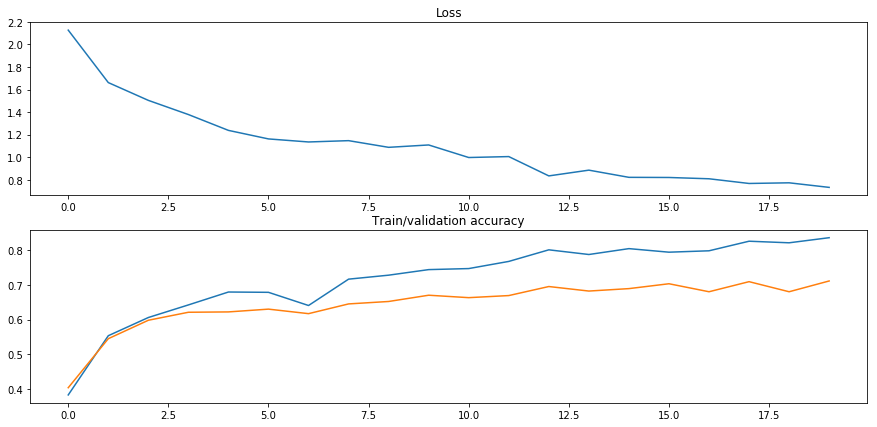

In [59]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [60]:
test_pred = best_classifier.model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.658000
